In [1]:
import pickle
import CO2_Dataset_Preparation
import CO2_functions
import CO2_Processing
from CO2_Dataset_Preparation import *
from CO2_functions import * 
from CO2_Processing import *

import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)
importlib.reload(CO2_Dataset_Preparation)

from CO2_Dataset_Preparation import *
from CO2_functions import *
from CO2_Processing import *

%load_ext rpy2.ipython

In [87]:
m = Processed_Set('Picarro',5,True)
m._retrieve_data('../CO2_Data_Processed/')

In [88]:
tower_proc = dwn_sample(m.data['Picarro'],1).copy()
vent_proc = dwn_sample(m.data['Vent'],1).copy()
df = pd.concat([tower_proc,vent_proc['m_dot']],axis=1)

Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds


In [89]:
rolls = [5,10,30,60,600]

def add_rolling_wind(df,rolls):

    dataframe = df.copy()

    for col in ['ANEM_X','ANEM_Y']:
        for roll in rolls:
            dataframe[f'{roll}_roll_{col}'] = dataframe[col].rolling(roll,center=True,min_periods=1).mean()

    w = wind_add(dataframe,'ANEM_X','ANEM_Y').copy()[['ws','wd']]
    dataframe[f'ws'] = w['ws']
    dataframe[f'wd'] = w['wd']

    for roll in rolls:
        w = wind_add(dataframe,f'{roll}_roll_ANEM_X',f'{roll}_roll_ANEM_Y').copy()[['ws','wd']]
        dataframe[f'{roll}_ws'] = w['ws']
        dataframe[f'{roll}_wd'] = w['wd']
    
    return dataframe

df=add_rolling_wind(df,rolls)

Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'


In [90]:
df = df.filter(regex='ws|wd|Pic')

In [91]:
cols = df.columns.drop(['Pic_CO2','Pic_CH4','Pic_Loc'])
def column_shifter(dataframe,cols,shift_num,**kwargs):
    for key,value in kwargs.items():
        if key == 'delete':
            del_col = value
        else:
            del_col = False
    
        
    df = dataframe.copy()
    for col in cols:
        df[f'{col}(t-{shift_num})'] = df[col].shift(periods=shift_num)    
    if del_col:
        df.drop(cols,axis=1,inplace=True)
    return df

shift_num = [5,10,20,30,45,60,90,120]
for sn in shift_num:
    df = column_shifter(df,cols,sn,delete=False)

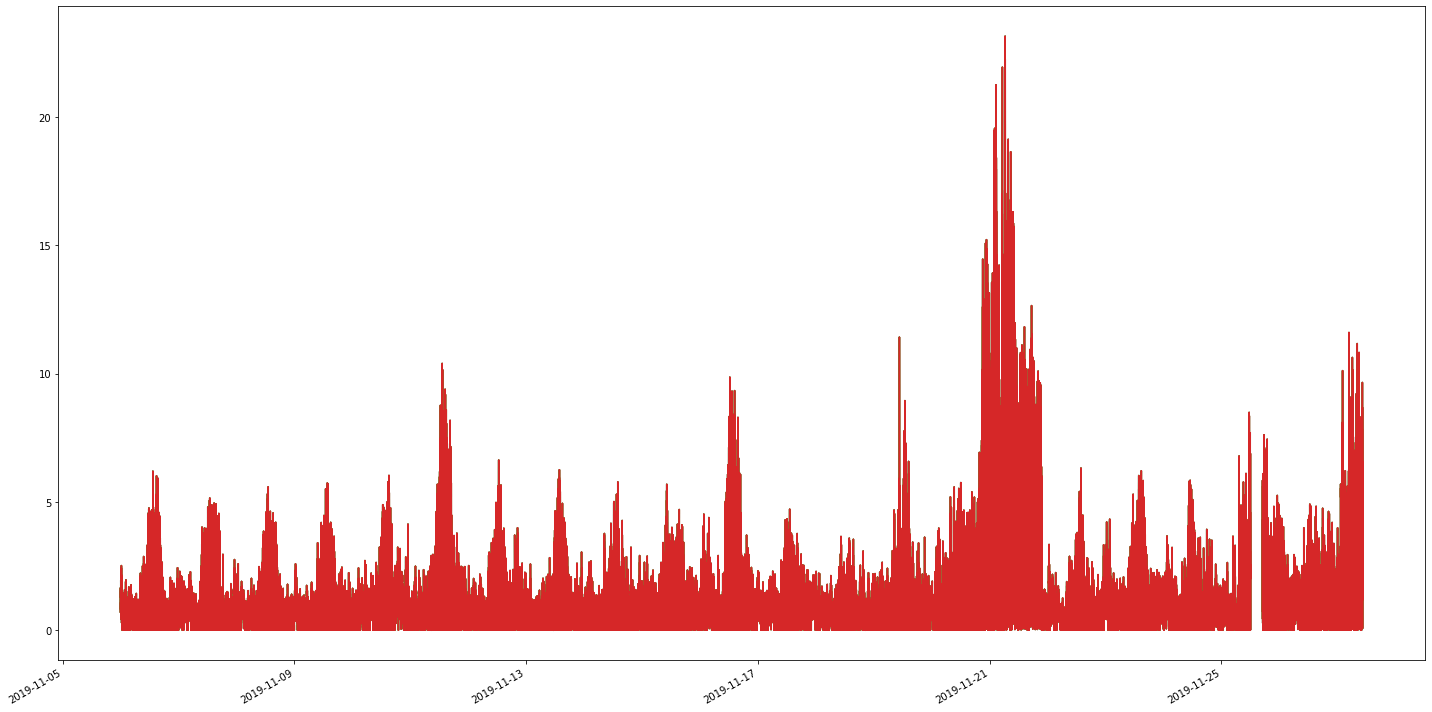

Is this an acceptable range? n
Input Start DateTime as YYYY-mm-DD HH:MM:SS - 2019-11-15 12:00:00
Input End DateTime as YYYY-mm-DD HH:MM:SS - 2019-11-15 12:03:00


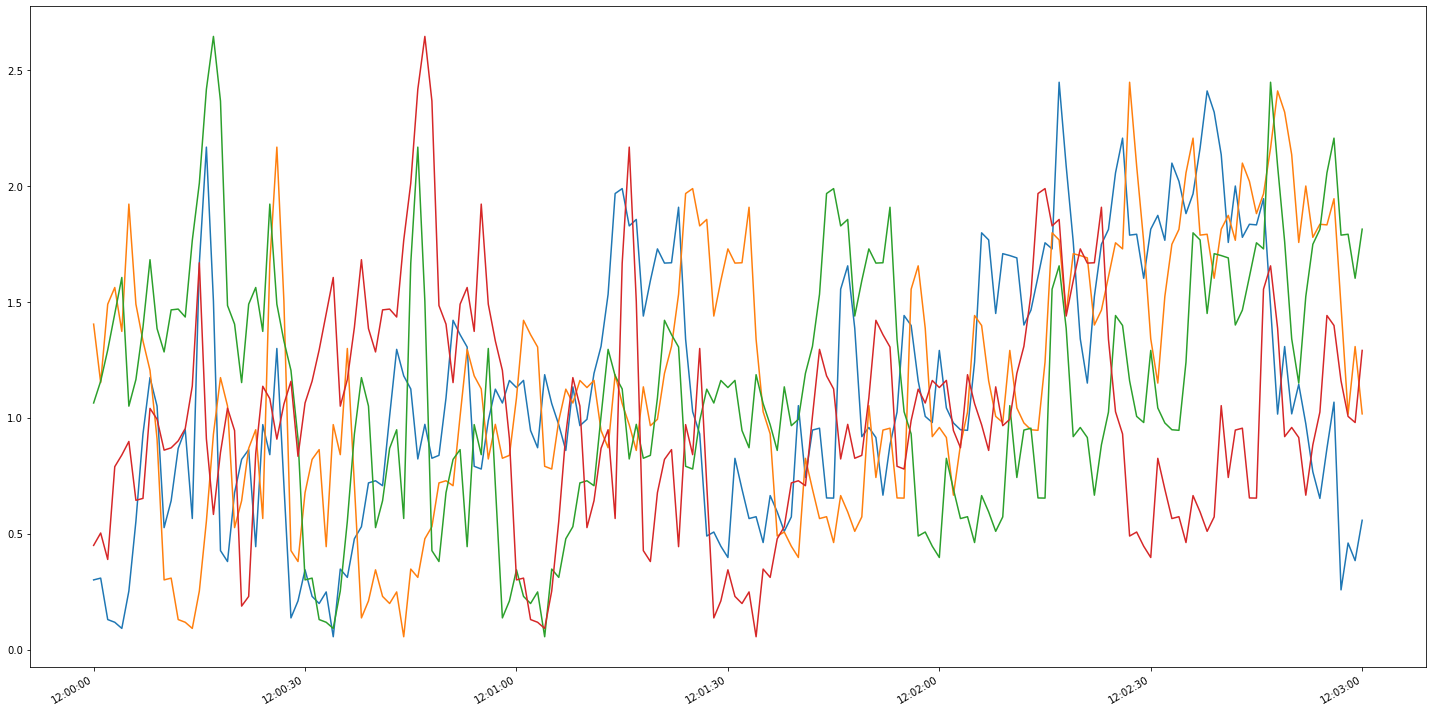

Is this an acceptable range? y


In [35]:
#new = wind_add(new,'ANEM_X','ANEM_Y')
graph = [\
         #[df_sub,'Corrected_DT','wd'],\
         #[df_sub,'Corrected_DT','10_wd'],\
         [df,'Corrected_DT','ws'],\
         [df,'Corrected_DT','ws(t-10)'],\
         [df,'Corrected_DT','ws(t-30)'],\
         [df,'Corrected_DT','ws(t-60)'],\
         #[dataframe,'Corrected_DT','3600_wd'],\
        ]

test_df = plot_refinement_all(graph,'stack')

# --------------------
# Baseline Testing
# --------------------

In [92]:
rolls = [5,10,30,60,600]
for roll in rolls:
    for col in ['Pic_CO2','Pic_CH4']:
        df[f'min_r{roll}_{col}'] = df[col].rolling(roll,center=True,min_periods=1).min()
        df[f'mean_r{roll}_{col}'] = df[col].rolling(roll,center=True,min_periods=1).mean()
        df[f'std_r{roll}_{col}'] = df[col].rolling(roll,center=True,min_periods=1).std()
        df[f'max_r{roll}_{col}'] = df[col].rolling(roll,center=True,min_periods=1).max()

for roll in rolls:
    for col in ['Pic_CO2','Pic_CH4']:
        df[f'excess_r{roll}_{col}'] = df[col]-df[f'min_r{roll}_{col}']
    #df[f'excess_std_{col}'] = df[f'excess_{col}'].rolling(roll).std()

In [193]:
#new = wind_add(new,'roll_ANEM_X','roll_ANEM_Y')
new_on = new.loc[new['m_dot']>0].copy()
inrange = new.loc[(new['wd']>180)&(new['wd']<270)].copy()
outrange = new.loc[~((new['wd']>180)&(new['wd']<270))].copy()
inrange_on = new_on.loc[(new_on['wd']>180)&(new_on['wd']<270)].copy()
outrange_on = new_on.loc[~((new_on['wd']>180)&(new_on['wd']<270))].copy()

outrange.mean()[['excess_Pic_CH4','Pic_CH4']]
inrange.mean()[['excess_Pic_CH4','Pic_CH4']]

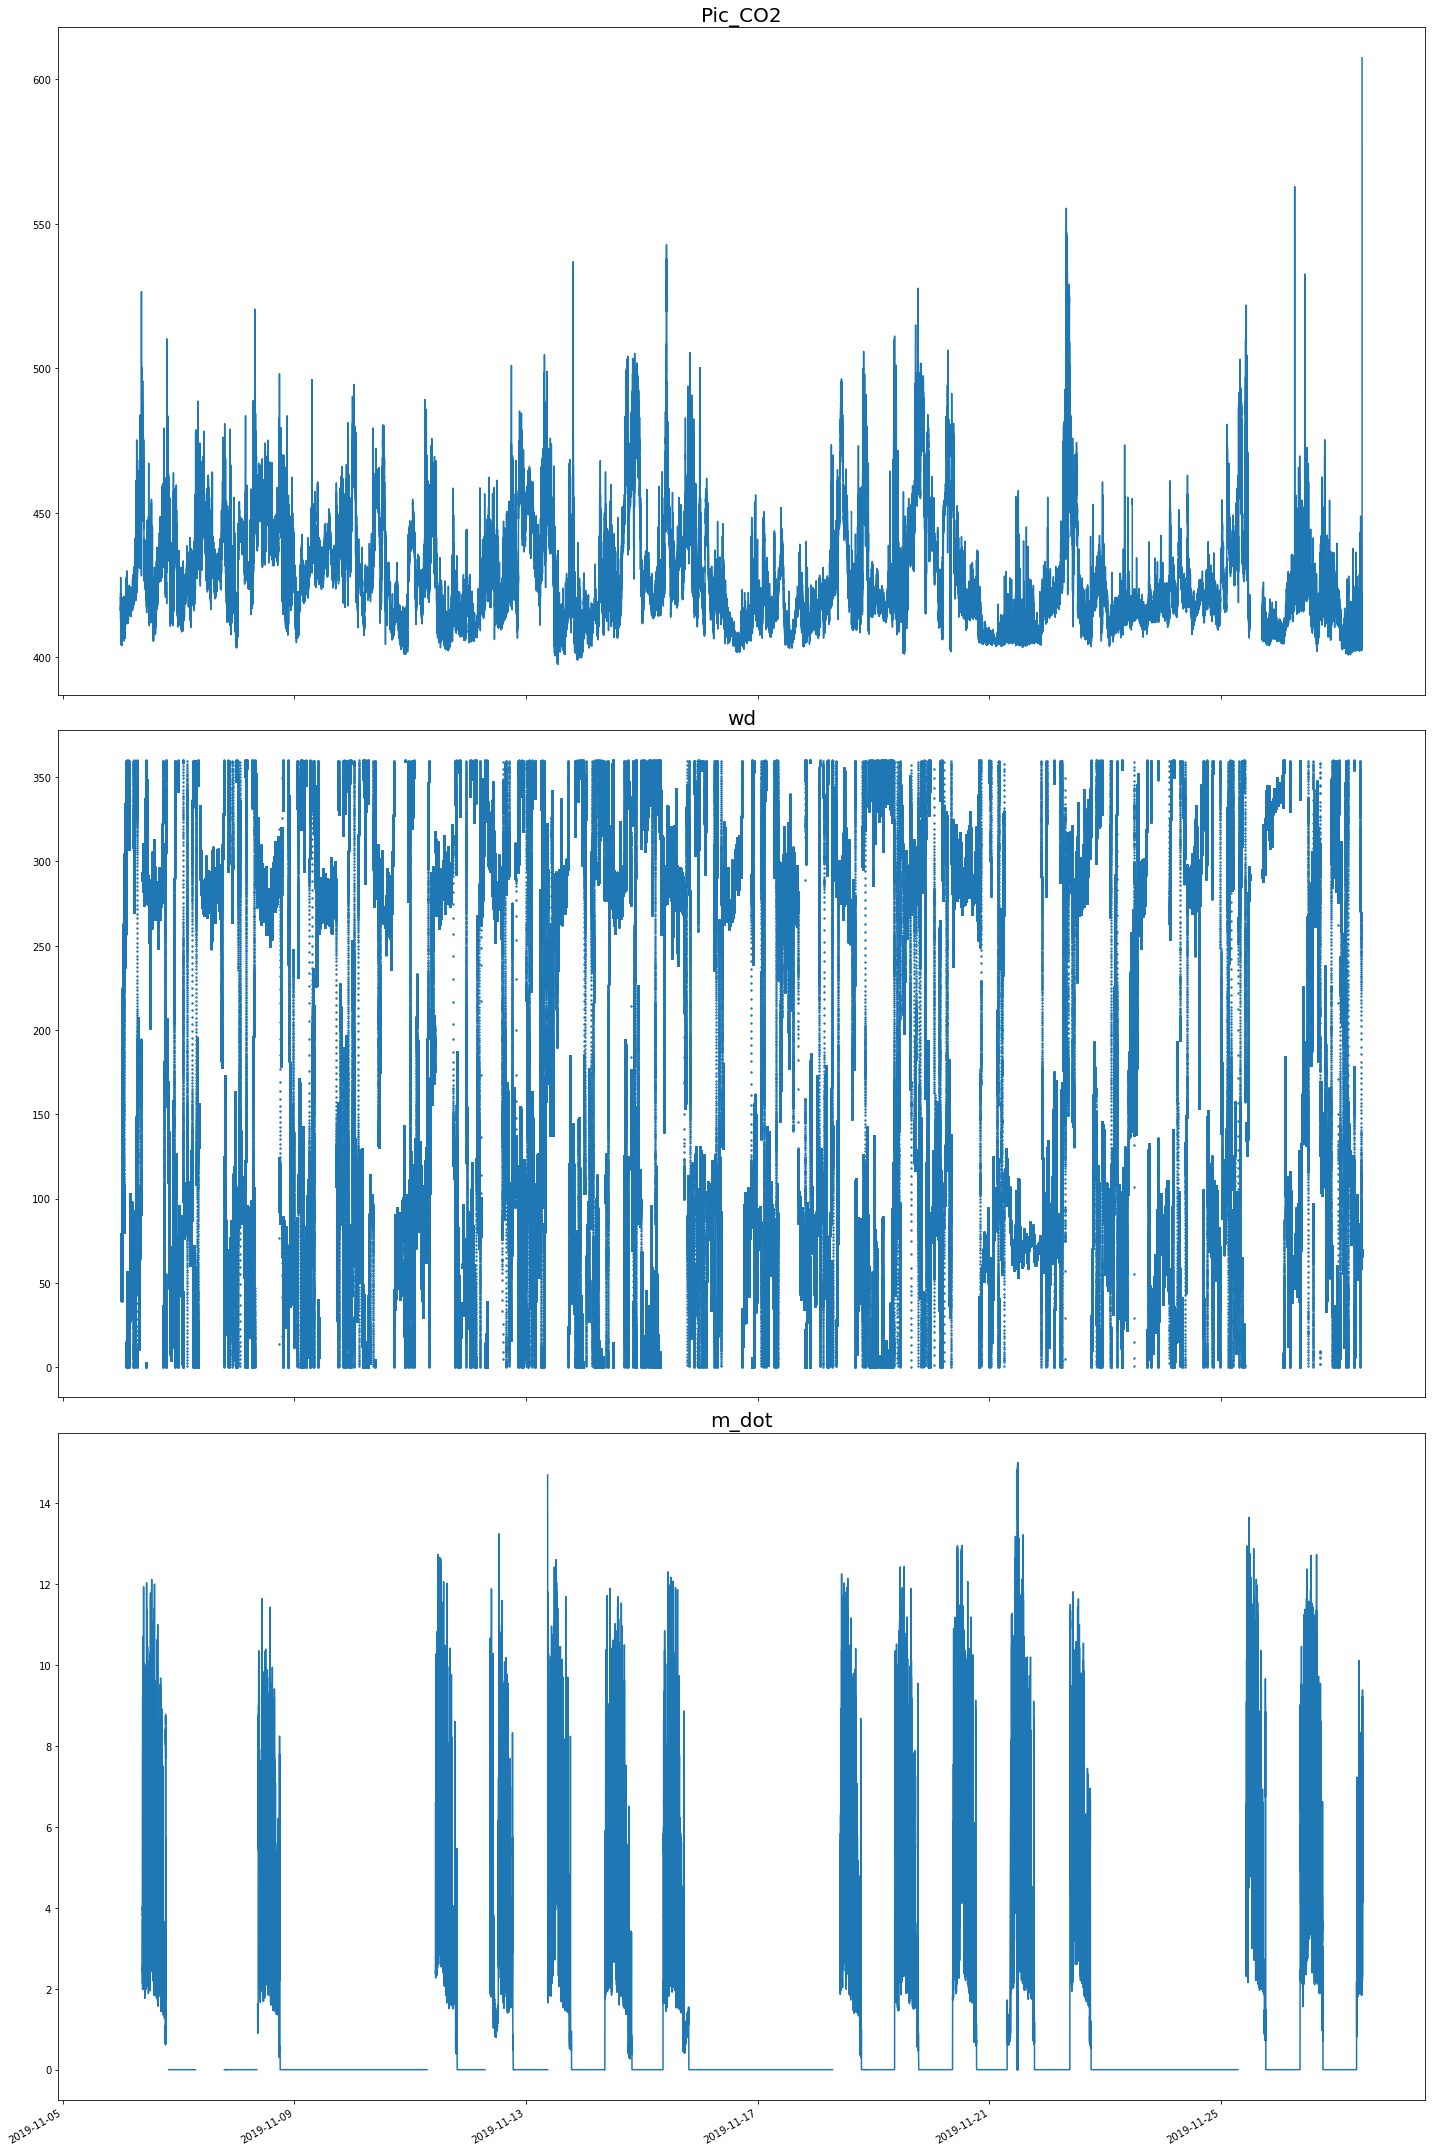

Is this an acceptable range? y


In [190]:
#new = wind_add(new,'ANEM_X','ANEM_Y')
graph = [\
         [new,'Corrected_DT','Pic_CO2'],\
         #[new,'Corrected_DT','excess_Pic_CH4'],\
         [new,'Corrected_DT','wd'],\
         [new,'Corrected_DT','m_dot']\
        ]

test_df = plot_refinement_all(graph,'separate')

# -----------------------------
# R
# -----------------------------

In [55]:
dir_test = pd.DataFrame({'ws':[5],'wd':[200]})

In [93]:
df

,Pic_CO2,Pic_CH4,Pic_Loc,ws,wd,5_ws,5_wd,10_ws,10_wd,30_ws,...,excess_r5_Pic_CO2,excess_r5_Pic_CH4,excess_r10_Pic_CO2,excess_r10_Pic_CH4,excess_r30_Pic_CO2,excess_r30_Pic_CH4,excess_r60_Pic_CO2,excess_r60_Pic_CH4,excess_r600_Pic_CO2,excess_r600_Pic_CH4
Corrected_DT,,,,,,,,,,,,,,,,,,,,,
2019-10-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-16 00:00:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-16 00:00:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-16 00:00:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-16 00:00:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-04 23:59:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-04 23:59:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-04 23:59:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# df = dataframe.copy()
# pic = df.resample("10S").mean()#.agg(dict(Pic_CO2='max',Pic_CH4='max',ANEM_Y='mean',ANEM_X='mean',ANEM_Z='mean',Pic_Loc = 'last'))
# pic = wind_add(pic,'ANEM_X','ANEM_Y')

import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

print('here')
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df)

here


In [95]:
%%R -i r_df
.libPaths()
write.csv(r_df,file='../CO2_Data_Processed/R_Dataframes/Pic_PN5.Rdat')

<img src="Openair/data.jpg">

# ---------------------------------
# DASH/PLOTLY
# ---------------------------------

In [ ]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np
from scipy import special

py.offline.init_notebook_mode(connected=True)

In [ ]:
d = vent_data_all
x = d.index

layout = go.Layout(
    title = 'Vent_Data',
    yaxis = dict(
        title = 'Mass Flow (g/s)'
    ),
    xaxis = dict(
        title = 'Date Time'
    )
)

trace1 = go.Scattergl(
    x = x,
    y = d['m_dot'],
    mode = 'lines',
    name = 'm_dot',
)

fig = go.Figure(data=trace1,layout=layout)
py.offline.iplot(fig)
    


In [ ]:
x = d.index

layout = go.Layout(
    title = 'SIM',
    yaxis = dict(
        title = 'volts'
    ),
    xaxis = dict(
        title = 'ns'
    )
)


def update_plot(CO2_x, roll):
    data = []
    print(roll)
    for c in CO2_x:
        trace1 = go.Scattergl(
            x = x,
            y = d.rolling(roll,center=True,min_periods=1).mean()[f'CO2_{c}'],
            mode = 'lines',
            name = 'CO2_{}'.format(c),
#             line=dict(
#                 shape='spline'
#             )
        )
        data.append(trace1)
    fig = go.Figure(data=data,layout=layout)
    py.offline.iplot(fig)
    
    

CO2_x = widgets.SelectMultiple(options=list(range(1,4)),value=(1,),description='CO2')
roll = widgets.Select(
    options = [1,10,100,1000],
    value = 1,
    description='roll'    
)

widgets.interactive(update_plot,CO2_x=CO2_x,roll=roll)